In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image



# part B

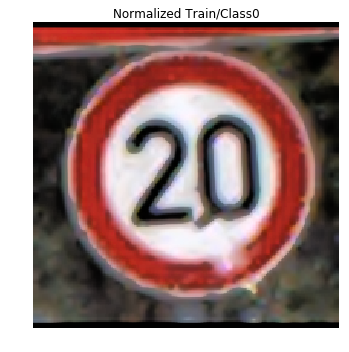

In [14]:

## Normalization

def pad_to_square(img):
    h, w = img.shape[:2]
    diff = abs(h - w)
    if h > w:
        pad = ((0, 0), (diff // 2, diff - diff // 2), (0, 0))
    else:
        pad = ((diff // 2, diff - diff // 2), (0, 0), (0, 0))
    return np.pad(img, pad, mode='constant', constant_values=0)

def normalize_brightness_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]
    v = cv2.equalizeHist(v)  # Histogram equalization on V channel
    hsv[:, :, 2] = v
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def normalize_image(image_path, target_size=(200, 200), normalize_brightness=False):
    # Load image using PIL then convert to NumPy array
    img = np.array(Image.open(image_path).convert("RGB"))

    # Pad to square
    img = pad_to_square(img)

    # Resize to fixed size
    img = np.array(Image.fromarray(img).resize(target_size))

    # Normalize brightness (optional)
    if normalize_brightness:
        img = normalize_brightness_hsv(img)

    # Placeholder for rotation correction — you can fill this based on ShapeId
    # For example: if shape is triangle and appears inverted, rotate it
    # img = rotate_image(img, angle)  # to be implemented

    return img


normalized_img = normalize_image("/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png", normalize_brightness=True)

plt.figure(figsize=(5, 5))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Train/Class0")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.show()

In [ ]:
# Apply mean filter on RGB → then convert to HSV → then segment

# Apply grayscale + Gaussian smoothing before edge detection

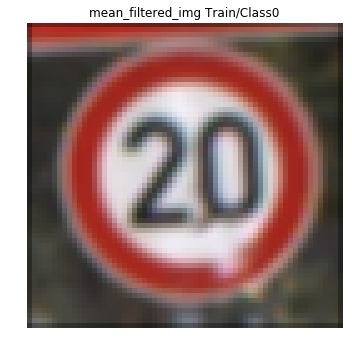

In [16]:
# Mean filter

def apply_mean_filter(image):
    """Apply 3x3 mean filter on an RGB image (NumPy array)."""
    # Ensure image is a NumPy array
    img = np.array(image)
    
    # Pad the image with 1 pixel border to handle edges
    padded = np.pad(img, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    
    # Prepare an empty array for the output
    filtered = np.zeros_like(img)

    # Loop through each pixel (excluding padding)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(3):  # for each color channel (R, G, B)
                region = padded[i:i+3, j:j+3, c]
                filtered[i, j, c] = np.mean(region)
    
    return filtered.astype(np.uint8)

img = Image.open("/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png").convert("RGB")
img_np = np.array(img)

mean_filtered_img = apply_mean_filter(img_np)


plt.figure(figsize=(5, 5))
plt.imshow(mean_filtered_img, cmap='gray')
plt.title("mean_filtered_img Train/Class0")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.show()

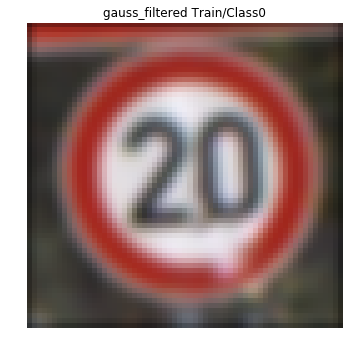

In [ ]:
# gussian


def gaussian_kernel(size=3, sigma=1.0):
    """Create a Gaussian kernel with given size and sigma."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def apply_gaussian_filter(image, kernel_size=3, sigma=1.0):
    """Apply Gaussian filter to an RGB image using NumPy."""
    img = np.array(image)
    kernel = gaussian_kernel(kernel_size, sigma)
    pad = kernel_size // 2
    
    # Pad the image
    padded = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    filtered = np.zeros_like(img)
    
    # Convolve kernel over each pixel and channel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(3):  # RGB channels
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                filtered[i, j, c] = np.sum(region * kernel)
    
    return np.clip(filtered, 0, 255).astype(np.uint8)


img = Image.open("/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png").convert("RGB")
gauss_filtered = apply_gaussian_filter(img, kernel_size=5, sigma=1.4)
plt.figure(figsize=(5, 5))
plt.imshow(gauss_filtered, cmap='gray')
plt.title("gauss_filtered Train/Class0")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.show()


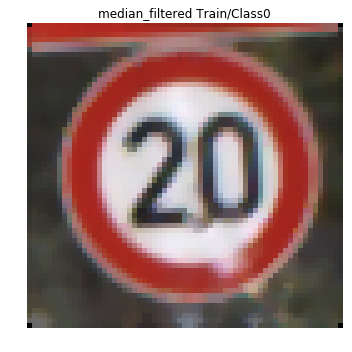

In [19]:
# median

import numpy as np
from PIL import Image

def apply_median_filter(image, kernel_size=3):
    """Apply a median filter to an RGB image."""
    img = np.array(image)
    pad = kernel_size // 2

    # Pad the image to handle edges
    padded = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    filtered = np.zeros_like(img)

    # Loop through image pixels
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(3):  # For R, G, B channels
                region = padded[i:i+kernel_size, j:j+kernel_size, c]
                filtered[i, j, c] = np.median(region)
    
    return filtered.astype(np.uint8)

img = Image.open("/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png").convert("RGB")
median_filtered = apply_median_filter(img)

plt.figure(figsize=(5, 5))
plt.imshow(median_filtered, cmap='gray')
plt.title("median_filtered Train/Class0")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.show()




/home/abdullah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/home/abdullah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


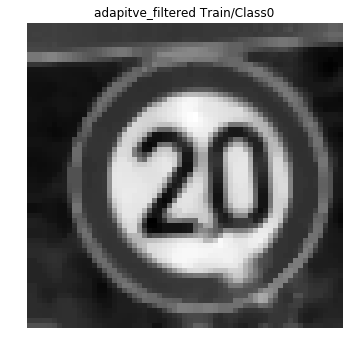

In [20]:
# adaptive median

def adaptive_median_filter(image, max_kernel_size=7):
    """Apply adaptive median filter to a grayscale image."""
    img = np.array(image)
    if img.ndim == 3:
        raise ValueError("Adaptive median filter expects a grayscale image.")
    
    padded = np.pad(img, max_kernel_size // 2, mode='edge')
    output = np.zeros_like(img)

    height, width = img.shape

    for i in range(height):
        for j in range(width):
            k = 3  # starting kernel size
            pixel_set = False
            
            while k <= max_kernel_size and not pixel_set:
                half = k // 2
                window = padded[i:i+k, j:j+k]
                Zmin = np.min(window)
                Zmax = np.max(window)
                Zmed = np.median(window)
                A1 = Zmed - Zmin
                A2 = Zmed - Zmax

                if A1 > 0 and A2 < 0:
                    B1 = img[i, j] - Zmin
                    B2 = img[i, j] - Zmax
                    if B1 > 0 and B2 < 0:
                        output[i, j] = img[i, j]
                    else:
                        output[i, j] = Zmed
                    pixel_set = True
                else:
                    k += 2  # increase window size (must be odd)
            
            if not pixel_set:
                output[i, j] = Zmed  # fallback
    
    return output.astype(np.uint8)




# Convert RGB to grayscale first
gray_img = Image.open("/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png").convert("L")

adpt_filtered = adaptive_median_filter(gray_img, max_kernel_size=7)

plt.figure(figsize=(5, 5))
plt.imshow(adpt_filtered, cmap='gray')
plt.title("adapitve_filtered Train/Class0")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.show()



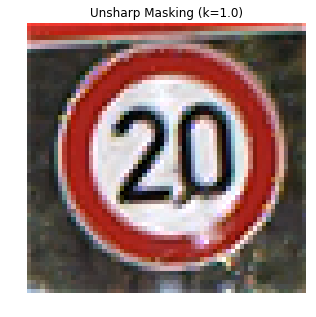

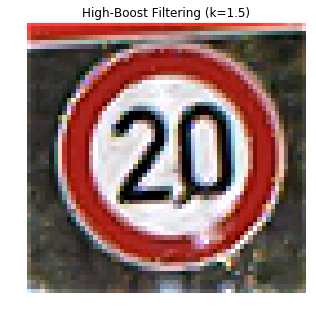

In [22]:
# unsharping and high boast filtering

def unsharp_masking(image, k=1.0, sigma=1.0, kernel_size=5):
    """
    Apply unsharp masking or high-boost filtering using custom Gaussian blur.
    k = 1.0 → unsharp masking
    k > 1.0 → high-boost filtering
    """
    img = np.array(image).astype(np.float32)

    if img.ndim == 3:  # RGB
        blurred = apply_gaussian_filter(img, kernel_size=kernel_size, sigma=sigma)
        mask = img - blurred
        sharpened = img + k * mask
    else:  # Grayscale
        blurred = apply_gaussian_filter(img, kernel_size=kernel_size, sigma=sigma)
        mask = img - blurred
        sharpened = img + k * mask

    return np.clip(sharpened, 0, 255).astype(np.uint8)

# Step 3: Test on an image
img_path = "/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Train/0/00000_00000_00022.png"
img = Image.open(img_path).convert("RGB")

# Unsharp masking
sharpened = unsharp_masking(img, k=1.0, sigma=1.0)

plt.figure(figsize=(5, 5))
plt.imshow(sharpened)
plt.title("Unsharp Masking (k=1.0)")
plt.axis("off")
plt.show()

# High-boost filtering
boosted = unsharp_masking(img, k=1.5, sigma=1.0)

plt.figure(figsize=(5, 5))
plt.imshow(boosted)
plt.title("High-Boost Filtering (k=1.5)")
plt.axis("off")
plt.show()

# Part C

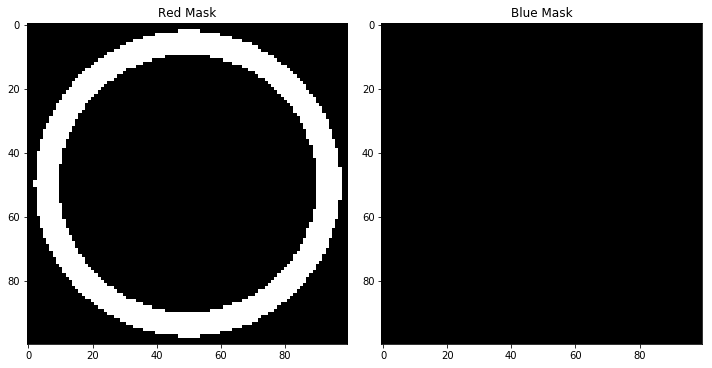

In [31]:

def rgb_to_hsv_manual(image):
    """Convert an RGB image to HSV using NumPy (manual implementation)."""
    image = image.astype('float32') / 255.0
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    cmax = np.max(image, axis=2)
    cmin = np.min(image, axis=2)
    delta = cmax - cmin

    # Hue calculation
    hue = np.zeros_like(cmax)
    mask = delta != 0

    idx = (cmax == r) & mask
    hue[idx] = (60 * ((g[idx] - b[idx]) / delta[idx]) + 360) % 360
    idx = (cmax == g) & mask
    hue[idx] = (60 * ((b[idx] - r[idx]) / delta[idx]) + 120) % 360
    idx = (cmax == b) & mask
    hue[idx] = (60 * ((r[idx] - g[idx]) / delta[idx]) + 240) % 360

    # Saturation
    saturation = np.zeros_like(cmax)
    saturation[cmax != 0] = delta[cmax != 0] / cmax[cmax != 0]

    # Value
    value = cmax

    hsv = np.stack((hue, saturation * 100, value * 100), axis=2)
    return hsv

def create_red_blue_masks(hsv_img):
    """Return binary masks for red and blue regions using dynamic thresholds."""
    hue = hsv_img[..., 0]
    sat = hsv_img[..., 1]
    val = hsv_img[..., 2]

    # Red mask (updated dynamic thresholds)
    red_mask_low = (hue >= 0) & (hue <= 20)
    red_mask_high = (hue >= 280) & (hue <= 310)
    red_hue_mask = red_mask_low | red_mask_high
    red_mask = red_hue_mask & (sat >= 40) & (val >= 30)

    # Blue mask (conservative dynamic estimate)
    blue_mask = (hue >= 190) & (hue <= 250) & (sat >= 40) & (val >= 30)

    return red_mask.astype(np.uint8), blue_mask.astype(np.uint8)

# Load image
img_path = "/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Meta/0.png"
img = np.array(Image.open(img_path).convert("RGB"))

# Convert and segment
hsv = rgb_to_hsv_manual(img)
red_mask, blue_mask = create_red_blue_masks(hsv)

# Show masks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(red_mask, cmap='gray')
plt.title("Red Mask")

plt.subplot(1, 2, 2)
plt.imshow(blue_mask, cmap='gray')
plt.title("Blue Mask")

plt.tight_layout()
plt.show()


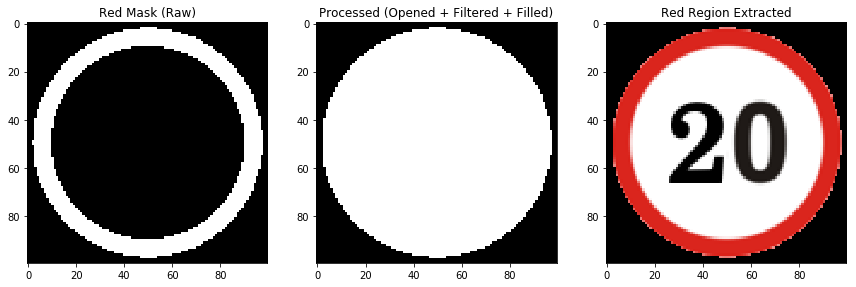

In [29]:
# ------------------------
# Step 1: RGB to HSV
# ------------------------
def rgb_to_hsv_manual(image):
    image = image.astype('float32') / 255.0
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    cmax = np.max(image, axis=2)
    cmin = np.min(image, axis=2)
    delta = cmax - cmin

    hue = np.zeros_like(cmax)
    mask = delta != 0

    idx = (cmax == r) & mask
    hue[idx] = (60 * ((g[idx] - b[idx]) / delta[idx]) + 360) % 360
    idx = (cmax == g) & mask
    hue[idx] = (60 * ((b[idx] - r[idx]) / delta[idx]) + 120) % 360
    idx = (cmax == b) & mask
    hue[idx] = (60 * ((r[idx] - g[idx]) / delta[idx]) + 240) % 360

    saturation = np.zeros_like(cmax)
    saturation[cmax != 0] = delta[cmax != 0] / cmax[cmax != 0]
    value = cmax

    return np.stack((hue, saturation * 100, value * 100), axis=2)

# ------------------------
# Step 2: Color Mask Creation
# ------------------------
def create_red_blue_masks(hsv_img):
    hue, sat, val = hsv_img[..., 0], hsv_img[..., 1], hsv_img[..., 2]

    red_mask_low = (hue >= 0) & (hue <= 20)
    red_mask_high = (hue >= 280) & (hue <= 310)
    red_mask = (red_mask_low | red_mask_high) & (sat >= 40) & (val >= 30)

    blue_mask = (hue >= 190) & (hue <= 250) & (sat >= 40) & (val >= 30)

    return red_mask.astype(np.uint8), blue_mask.astype(np.uint8)

# ------------------------
# Step 3: Morphological Operations (Opening = Erosion + Dilation)
# ------------------------
def erode(mask):
    padded = np.pad(mask, 1, mode='constant', constant_values=0)
    eroded = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            region = padded[i:i+3, j:j+3]
            eroded[i, j] = np.min(region)
    return eroded

def dilate(mask):
    padded = np.pad(mask, 1, mode='constant', constant_values=0)
    dilated = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            region = padded[i:i+3, j:j+3]
            dilated[i, j] = np.max(region)
    return dilated

def opening(mask):
    return dilate(erode(mask))

# ------------------------
# Step 4: Connected Component Filtering (Pure NumPy DFS)
# ------------------------
def connected_components_filter(mask, area_threshold=100):
    visited = np.zeros_like(mask, dtype=bool)
    output = np.zeros_like(mask)
    label = 1

    def dfs(x, y, coords):
        stack = [(x, y)]
        while stack:
            i, j = stack.pop()
            if (0 <= i < mask.shape[0]) and (0 <= j < mask.shape[1]):
                if not visited[i, j] and mask[i, j]:
                    visited[i, j] = True
                    coords.append((i, j))
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if dx != 0 or dy != 0:
                                stack.append((i + dx, j + dy))

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] and not visited[i, j]:
                region = []
                dfs(i, j, region)
                if len(region) >= area_threshold:
                    for (x, y) in region:
                        output[x, y] = 1
    return output

# ------------------------
# Step 5: Hole Filling (Simple flood fill from border)
# ------------------------
def fill_holes(mask):
    filled = np.copy(mask)
    h, w = mask.shape
    visited = np.zeros_like(mask, dtype=bool)

    def flood_fill(x, y):
        stack = [(x, y)]
        while stack:
            i, j = stack.pop()
            if 0 <= i < h and 0 <= j < w:
                if not visited[i, j] and mask[i, j] == 0:
                    visited[i, j] = True
                    filled[i, j] = 1
                    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                        stack.append((i+dx, j+dy))

    # Fill from border
    for i in range(h):
        if not visited[i, 0]: flood_fill(i, 0)
        if not visited[i, w-1]: flood_fill(i, w-1)
    for j in range(w):
        if not visited[0, j]: flood_fill(0, j)
        if not visited[h-1, j]: flood_fill(h-1, j)

    return mask | (~visited).astype(np.uint8)

# ------------------------
# Step 6: Apply to Image
# ------------------------
img_path = "/home/abdullah/Desktop/SEMESTER_6/DIP/DIP_PROJECT/Buttu/Meta/0.png"
img = np.array(Image.open(img_path).convert("RGB"))

hsv = rgb_to_hsv_manual(img)
red_mask, _ = create_red_blue_masks(hsv)

binary = (red_mask > 0).astype(np.uint8)
opened = opening(binary)
cleaned = connected_components_filter(opened, area_threshold=100)
filled = fill_holes(cleaned)

# ------------------------
# Visualization
# ------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(red_mask, cmap='gray')
plt.title("Red Mask (Raw)")

plt.subplot(1, 3, 2)
plt.imshow(filled, cmap='gray')
plt.title("Processed (Opened + Filtered + Filled)")

plt.subplot(1, 3, 3)
masked_img = img.copy()
masked_img[filled == 0] = 0
plt.imshow(masked_img)
plt.title("Red Region Extracted")

plt.tight_layout()
plt.show()
